In [1]:
import datarobot as dr
import pandas as pd
from dask import delayed, compute
import matplotlib.pylab as plt
import seaborn as sns
import deployment_patch
plt.style.use('dark_background')


In [ ]:
start = datetime.datetime.now()

In [3]:
dr.Client(endpoint='https://app.eu.datarobot.com/api/v2/', 
          token='NWQ1NDA5NTkyYTkxNDQ0MmYzMTMzMjZlOlhkS013bHptMzdHTmZvZjJvNDgyTl9MUWZKV1NWeFVK')

In [3]:
df = pd.read_csv('10K_Lending_Club_Loans.csv')

In [6]:
df.head()

,loan_amnt,funded_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,...,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,mths_since_last_major_derog,policy_code,is_bad
0,4000,4000,60 months,7.29%,79.76,A,A4,Time Warner Cable,10+ years,MORTGAGE,...,NaN,15.0,0.0,12087,12.1,44.0,f,NaN,1,0
1,16000,16000,60 months,18.25%,408.48,F,F1,Ottawa University,< 1 year,RENT,...,NaN,4.0,0.0,10114,64.0,5.0,f,NaN,1,0
2,8700,8700,36 months,7.88%,272.15,A,A5,Kennedy Wilson,4 years,RENT,...,NaN,4.0,0.0,81,0.6,8.0,f,NaN,1,0
3,18000,18000,60 months,11.49%,395.78,B,B4,TOWN OF PLATTEKILL,10+ years,MORTGAGE,...,NaN,6.0,0.0,10030,37.1,23.0,f,NaN,1,0
4,16000,16000,36 months,11.83%,530.15,B,B3,Belmont Correctional,10+ years,MORTGAGE,...,NaN,8.0,0.0,10740,40.4,21.0,f,NaN,1,0


In [4]:
project = [p for p in dr.Project.list() if p.project_name == "AutoML_model_factory"][0]

In [5]:
bps = project.get_blueprints()

In [8]:
[bp for bp in bps if 'Elastic' in bp.model_type]

[Blueprint(Elastic-Net Classifier (L1 / Binomial Deviance)),
 Blueprint(Elastic-Net Classifier (L2 / Binomial Deviance)),
 Blueprint(Elastic-Net Classifier (L2 / Binomial Deviance)),
 Blueprint(Elastic-Net Classifier (L2 / Binomial Deviance)),
 Blueprint(Elastic-Net Classifier with Naive Bayes Feature Weighting (L2)),
 Blueprint(Elastic-Net Classifier (mixing alpha=0.5 / Binomial Deviance)),
 Blueprint(Elastic-Net Classifier (L1 / Binomial Deviance)),
 Blueprint(Elastic-Net Classifier (L2 / Binomial Deviance)),
 Blueprint(Elastic-Net Classifier (L2 / Binomial Deviance) with Binned numeric features),
 Blueprint(Light Gradient Boosting on ElasticNet Predictions ),
 Blueprint(Elastic-Net Classifier (mixing alpha=0.5 / Binomial Deviance)),
 Blueprint(Elastic-Net Classifier (L2 / Binomial Deviance)),
 Blueprint(Elastic-Net Classifier (L2 / Binomial Deviance)),
 Blueprint(Elastic-Net Classifier (mixing alpha=0.5 / Binomial Deviance) with Unsupervised Learning Features),
 Blueprint(Elastic-Ne

In [4]:
project = dr.Project.create(df, project_name="AutoML_model_factory") 
project.set_target('is_bad', worker_count=-1, mode=dr.enums.AUTOPILOT_MODE.QUICK)

Project(AutoML_model_factory)

In [12]:
project.get_leaderboard_ui_permalink()

'https://app.eu.datarobot.com/projects/614ddba28dc6de4b2a99c63e/models'

In [5]:
project.wait_for_autopilot()

In progress: 13, queued: 0 (waited: 0s)
In progress: 13, queued: 0 (waited: 1s)
In progress: 13, queued: 0 (waited: 2s)
In progress: 13, queued: 0 (waited: 4s)
In progress: 13, queued: 0 (waited: 6s)
In progress: 13, queued: 0 (waited: 9s)
In progress: 13, queued: 0 (waited: 13s)
In progress: 13, queued: 0 (waited: 21s)
In progress: 13, queued: 0 (waited: 36s)
In progress: 12, queued: 0 (waited: 57s)
In progress: 7, queued: 0 (waited: 78s)
In progress: 2, queued: 0 (waited: 99s)
In progress: 1, queued: 0 (waited: 121s)
In progress: 1, queued: 0 (waited: 142s)
In progress: 8, queued: 0 (waited: 163s)
In progress: 8, queued: 0 (waited: 184s)
In progress: 8, queued: 0 (waited: 205s)
In progress: 8, queued: 0 (waited: 230s)
In progress: 5, queued: 0 (waited: 251s)
In progress: 4, queued: 0 (waited: 272s)
In progress: 1, queued: 0 (waited: 293s)
In progress: 1, queued: 0 (waited: 315s)
In progress: 0, queued: 0 (waited: 335s)
In progress: 16, queued: 0 (waited: 356s)
In progress: 12, queued

In [10]:
m = dr.ModelRecommendation.get(project.id).get_model()

In [13]:
m.advanced_tune()

Model('Light Gradient Boosting on ElasticNet Predictions ')

In [8]:
recommended_model = {'ProjectName': project.project_name, 
                     'ModelType': m.model_type, 
                     'FeatureList': m.featurelist_name,
                     'Model':m }

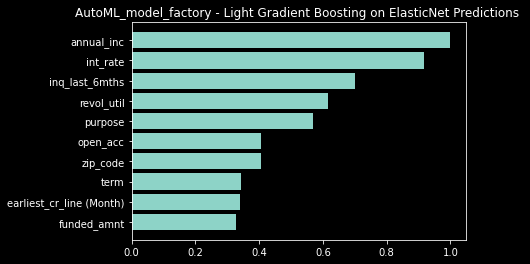

In [9]:
plt_data = pd.DataFrame.from_records(recommended_model['Model'].get_or_request_feature_impact()).sort_values('impactNormalized', ascending=True).tail(10)
ax = plt.barh(plt_data['featureName'], plt_data['impactNormalized'])
plt.title(f"{recommended_model['ProjectName']} - {recommended_model['ModelType']}")
plt.show()

In [14]:
prediction_servers = dr.PredictionServer.list()

In [15]:
deployment = dr.Deployment.create_from_learning_model(recommended_model['Model'].id, 
                                    label=f"Deployment {recommended_model['ProjectName']}", 
                                    default_prediction_server_id=prediction_servers[0].id)

In [26]:
for d in [deployment]:
    d.update_drift_tracking_settings(target_drift_enabled=True, feature_drift_enabled=True)
    d.update_predictions_data_collection_settings(enabled=True)
    d.update_association_id_settings(column_names=['id'])

In [51]:
pred_data = pd.read_csv('10K_Lending_Club_Loans.csv')
pred_data['id'] = pred_data.index

In [52]:
pred_data['id'] = pred_data.index
pred_data = pred_data.sample(10)

In [21]:
preds_df = deployment.predict(pred_data)

In [22]:
preds_df

,deploymentApprovalStatus,predictionThreshold,prediction,rowId,positiveClassPrediction
0,APPROVED,0.5,0.0,0,0.026290
1,APPROVED,0.5,0.0,1,0.025313
2,APPROVED,0.5,0.0,2,0.090036
3,APPROVED,0.5,0.0,3,0.056726
4,APPROVED,0.5,0.0,4,0.118278
...,...,...,...,...,...
95,APPROVED,0.5,0.0,95,0.094513
96,APPROVED,0.5,0.0,96,0.077269
97,APPROVED,0.5,0.0,97,0.245252
98,APPROVED,0.5,0.0,98,0.042922


In [27]:
preds_with_explanations_df = deployment.predict(pred_data, max_explanations=5, threshold_low=0, threshold_high=0)

In [28]:
preds_with_explanations_df

,deploymentApprovalStatus,rowId,predictionThreshold,prediction,passthroughValues,positiveClassPrediction,Explanation 1 featureValue,Explanation 1 strength,Explanation 1 feature,Explanation 1 qualitativeStrength,...,Explanation 4 featureValue,Explanation 4 strength,Explanation 4 feature,Explanation 4 qualitativeStrength,Explanation 4 label,Explanation 5 featureValue,Explanation 5 strength,Explanation 5 feature,Explanation 5 qualitativeStrength,Explanation 5 label
0,APPROVED,0,0.5,0.0,{'id': 3317},0.026290,5.99,-0.802758,int_rate,---,...,2.9,-0.171076,revol_util,--,1.0,36 months,-0.151164,term,--,1.0
1,APPROVED,1,0.5,0.0,{'id': 2820},0.025313,6.0,-1.134353,inq_last_6mths,---,...,Credit Card Loan,-0.136220,title,--,1.0,622.57,-0.108742,installment,--,1.0
2,APPROVED,2,0.5,0.0,{'id': 5896},0.090036,6.0,-0.543933,int_rate,---,...,D,0.135419,grade,++,1.0,FL,0.097134,addr_state,++,1.0
3,APPROVED,3,0.5,0.0,{'id': 2},0.056726,7.88,-0.320281,int_rate,--,...,AP Personal Loan,0.234760,title,++,1.0,A,-0.148911,grade,--,1.0
4,APPROVED,4,0.5,0.0,{'id': 7998},0.118278,38700.0,0.407827,annual_inc,+++,...,3600,-0.127057,loan_amnt,--,1.0,"Mid-Coast Fire Protection, Inc.",-0.119651,emp_title,--,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,APPROVED,95,0.5,0.0,{'id': 9474},0.094513,40000.0,0.397138,annual_inc,+++,...,B,-0.134667,grade,--,1.0,0.0,-0.108613,revol_util,--,1.0
96,APPROVED,96,0.5,0.0,{'id': 8989},0.077269,Borrower added on 09/29/10 > Personal Loan f...,0.245514,desc,++,...,18.3,-0.156205,revol_util,--,1.0,B,-0.118004,grade,--,1.0
97,APPROVED,97,0.5,0.0,{'id': 1333},0.245252,17.49,0.321249,int_rate,+++,...,D,0.191507,grade,++,1.0,Debt Consolidation Loan,0.172140,title,++,1.0
98,APPROVED,98,0.5,0.0,{'id': 2890},0.042922,6.54,-0.626435,int_rate,---,...,36 months,-0.116357,term,--,1.0,"Modern Door and Equipment Sales, Inc.",-0.106265,emp_title,--,1.0


In [3]:
!pip install git+https://github.com/MaximeJumelle/ALEPython.git@dev#egg=alepython

  Cloning https://github.com/MaximeJumelle/ALEPython.git (to revision dev) to /private/var/folders/wt/0vsxylyn7tz_gl2fhkh4bn600005dh/T/pip-install-xmdwtm_b/alepython_dd2c619c0a75421ab3d02e4d76e476ac
  Running command git clone -q https://github.com/MaximeJumelle/ALEPython.git /private/var/folders/wt/0vsxylyn7tz_gl2fhkh4bn600005dh/T/pip-install-xmdwtm_b/alepython_dd2c619c0a75421ab3d02e4d76e476ac
     |████████████████████████████████| 57 kB 1.7 MB/s eta 0:00:01
  Created wheel for alepython: filename=alepython-0.1.dev17+g286350a-py3-none-any.whl size=15022 sha256=d8c6558c345a6f0b8fec9b73844d9a5c19b1fb30293b7984e946038744be07db
  Stored in directory: /private/var/folders/wt/0vsxylyn7tz_gl2fhkh4bn600005dh/T/pip-ephem-wheel-cache-d490cdod/wheels/dc/0e/32/bbb5082ce85946e5d7b77a069cc1fd748855631153d53405bb
Successfully built alepython


In [4]:
d = dr.Deployment.get('60f9b0f9073e019e1cb9d47f')

In [5]:
d

Deployment(Deployment AutoML_model_factory)

In [6]:
pred_data = pd.read_csv('10K_Lending_Club_Loans.csv')[:1000]
pred_data['id'] = pred_data.index

In [7]:
pred_data

,loan_amnt,funded_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,...,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,mths_since_last_major_derog,policy_code,is_bad,id
0,4000,4000,60 months,7.29%,79.76,A,A4,Time Warner Cable,10+ years,MORTGAGE,...,15.0,0.0,12087,12.1,44.0,f,NaN,1,0,0
1,16000,16000,60 months,18.25%,408.48,F,F1,Ottawa University,< 1 year,RENT,...,4.0,0.0,10114,64.0,5.0,f,NaN,1,0,1
2,8700,8700,36 months,7.88%,272.15,A,A5,Kennedy Wilson,4 years,RENT,...,4.0,0.0,81,0.6,8.0,f,NaN,1,0,2
3,18000,18000,60 months,11.49%,395.78,B,B4,TOWN OF PLATTEKILL,10+ years,MORTGAGE,...,6.0,0.0,10030,37.1,23.0,f,NaN,1,0,3
4,16000,16000,36 months,11.83%,530.15,B,B3,Belmont Correctional,10+ years,MORTGAGE,...,8.0,0.0,10740,40.4,21.0,f,NaN,1,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3600,3600,36 months,11.36%,118.48,B,B5,"MIG, Inc.",4 years,RENT,...,9.0,0.0,9285,53.1,20.0,f,NaN,1,0,995
996,6000,6000,36 months,12.09%,199.55,C,C2,Southern California Gas Co,10+ years,OTHER,...,8.0,0.0,23958,87.1,34.0,f,NaN,1,0,996
997,6000,6000,36 months,8.00%,188.02,A,A3,BearingPoint,3 years,RENT,...,6.0,0.0,7161,16.4,9.0,f,NaN,1,0,997
998,8500,8500,36 months,5.79%,257.78,A,A2,wells fargo bank,5 years,RENT,...,9.0,0.0,4413,22.1,17.0,f,NaN,1,0,998


In [81]:
d.predict(pred_data)

,deploymentApprovalStatus,passthroughValues,rowId,predictionThreshold,prediction,positiveClassPrediction
0,APPROVED,{'id': 0},0,0.5,0.0,0.048040
1,APPROVED,{'id': 1},1,0.5,0.0,0.253721
2,APPROVED,{'id': 2},2,0.5,0.0,0.056726
3,APPROVED,{'id': 3},3,0.5,0.0,0.112320
4,APPROVED,{'id': 4},4,0.5,0.0,0.035154
...,...,...,...,...,...,...
995,APPROVED,{'id': 995},995,0.5,0.0,0.082561
996,APPROVED,{'id': 996},996,0.5,0.0,0.141669
997,APPROVED,{'id': 997},997,0.5,0.0,0.039522
998,APPROVED,{'id': 998},998,0.5,0.0,0.021024


In [82]:
d.predict(pred_data, max_explanations=5)

,deploymentApprovalStatus,rowId,predictionThreshold,prediction,passthroughValues,positiveClassPrediction,Explanation 1 featureValue,Explanation 1 strength,Explanation 1 feature,Explanation 1 qualitativeStrength,...,Explanation 4 featureValue,Explanation 4 strength,Explanation 4 feature,Explanation 4 qualitativeStrength,Explanation 4 label,Explanation 5 featureValue,Explanation 5 strength,Explanation 5 feature,Explanation 5 qualitativeStrength,Explanation 5 label
0,APPROVED,0,0.5,0.0,{'id': 0},0.048040,7.29,-0.836724,int_rate,---,...,A,-0.122045,grade,--,1.0,TX,-0.101998,addr_state,--,1.0
1,APPROVED,1,0.5,0.0,{'id': 1},0.253721,18.25,0.275925,int_rate,++,...,My Debt Consolidation Loan,0.175184,title,++,1.0,60 months,0.174844,term,++,1.0
2,APPROVED,2,0.5,0.0,{'id': 2},0.056726,7.88,-0.320281,int_rate,--,...,AP Personal Loan,0.234760,title,++,1.0,A,-0.148911,grade,--,1.0
3,APPROVED,3,0.5,0.0,{'id': 3},0.112320,60 months,0.334709,term,+++,...,Debt Consolidation Loan,0.102602,title,++,1.0,37.1,-0.089889,revol_util,--,1.0
4,APPROVED,4,0.5,0.0,{'id': 4},0.035154,4.0,-0.707103,inq_last_6mths,---,...,B3,0.108053,sub_grade,++,1.0,consolidate,0.098080,title,++,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,APPROVED,995,0.5,0.0,{'id': 995},0.082561,"MIG, Inc.",-0.170994,emp_title,---,...,50000.0,-0.073808,annual_inc,--,1.0,Borrower added on 04/30/10 > My rented home ...,0.069062,desc,++,1.0
996,APPROVED,996,0.5,0.0,{'id': 996},0.141669,I'm trying to start a small business selling ...,0.260876,desc,+++,...,C,0.134790,grade,++,1.0,0.0,0.084321,inq_last_6mths,++,1.0
997,APPROVED,997,0.5,0.0,{'id': 997},0.039522,I am a fiscally responsible adult purchasing a...,-0.326038,desc,---,...,100xx,-0.146768,zip_code,--,1.0,36 months,-0.137673,term,--,1.0
998,APPROVED,998,0.5,0.0,{'id': 998},0.021024,5.79,-0.826689,int_rate,---,...,A,-0.225995,grade,--,1.0,36 months,-0.182989,term,--,1.0


In [83]:
from alepython import ale_plot

In [49]:
pred_data = pred_data.drop(columns='is_bad')[:10]

In [85]:
pred_data = pred_data[~pred_data['annual_inc'].isna()]

In [86]:
import matplotlib.pylab as plt

In [87]:
def p(r):
#     print(r.index.values)
    preds = []
    for i in range((r.shape[0]-1)//1000+1):
#         print(r.iloc[i*1000:(i+1)*1000])
        pred = d.predict(r.iloc[i*1000:(i+1)*1000]).positiveClassPrediction
        preds.append(pred)
    asd = pd.concat(preds, axis=0)
#     print(asd)
    return asd

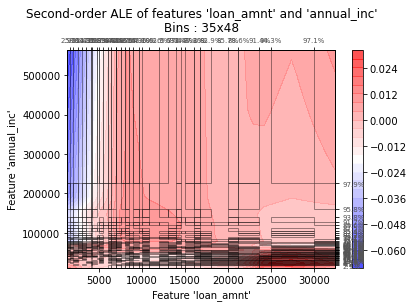

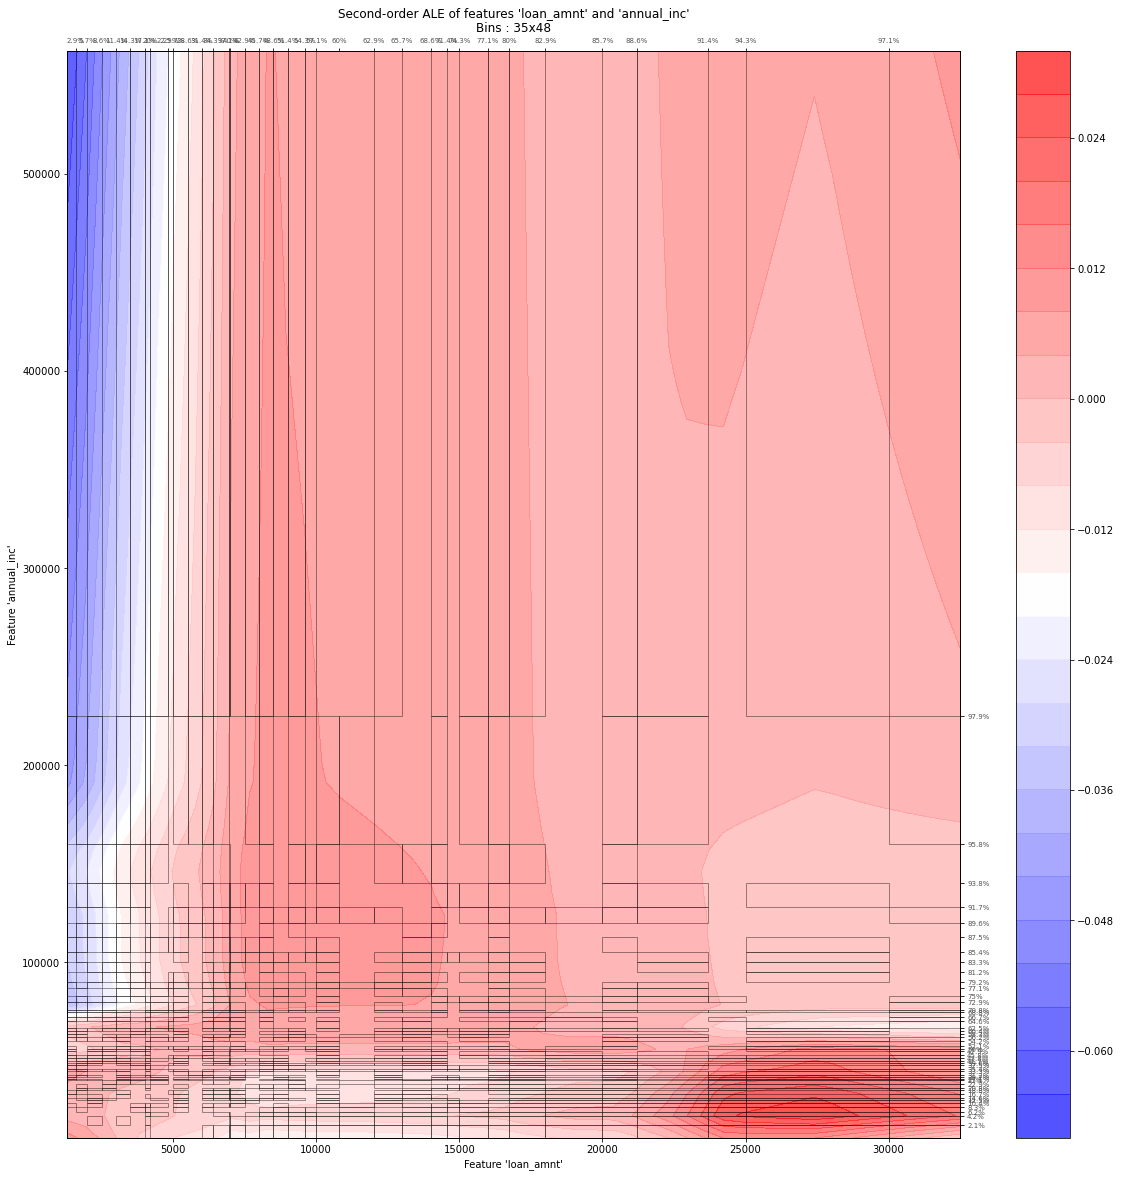

In [88]:
##### Plots ALE of feature 'cont' with Monte-Carlo replicas (default : 50).
fig1, ax1 = ale_plot(model=None, predictor=lambda r: d.predict(r).positiveClassPrediction, 
         train_set=pred_data, features=['loan_amnt', 'annual_inc'], monte_carlo=True, bins=50)
fig1.set_size_inches([20,20])
fig1

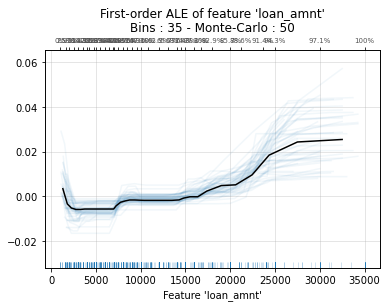

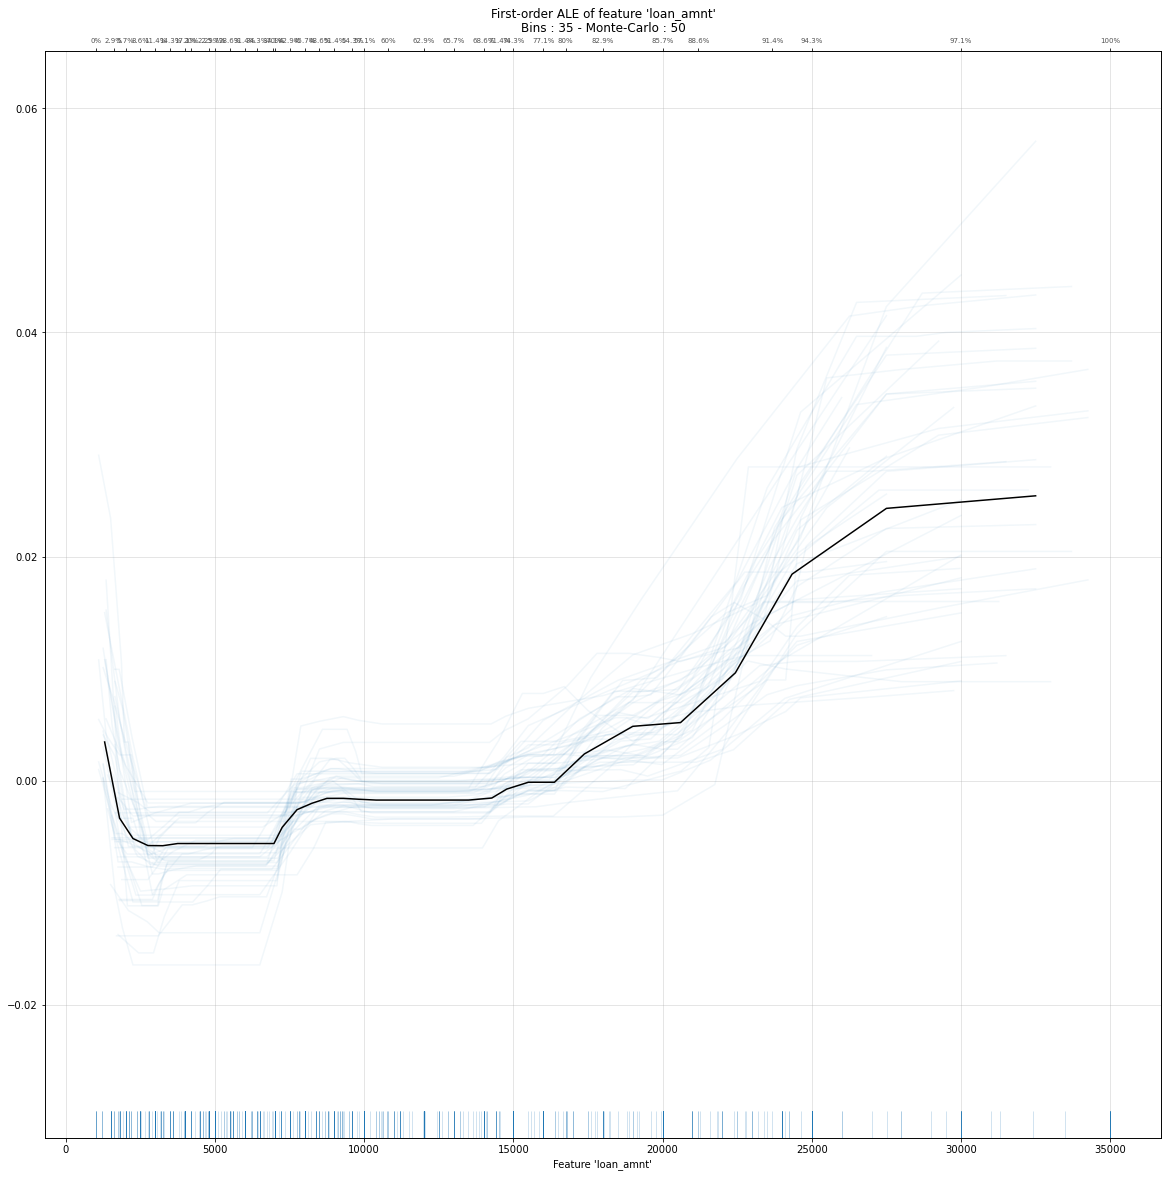

In [90]:
##### Plots ALE of feature 'cont' with Monte-Carlo replicas (default : 50).
fig2, ax2 = ale_plot(model=None, predictor=lambda r: d.predict(r).positiveClassPrediction, 
         train_set=pred_data, features=['loan_amnt'], monte_carlo=True, bins=50, 
                     rugplot_lim=None)
fig2.set_size_inches([20,20])
fig2

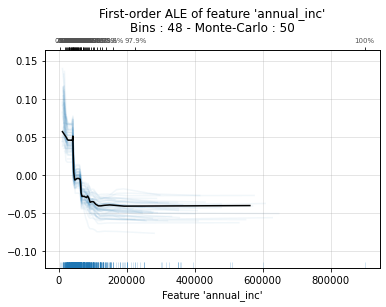

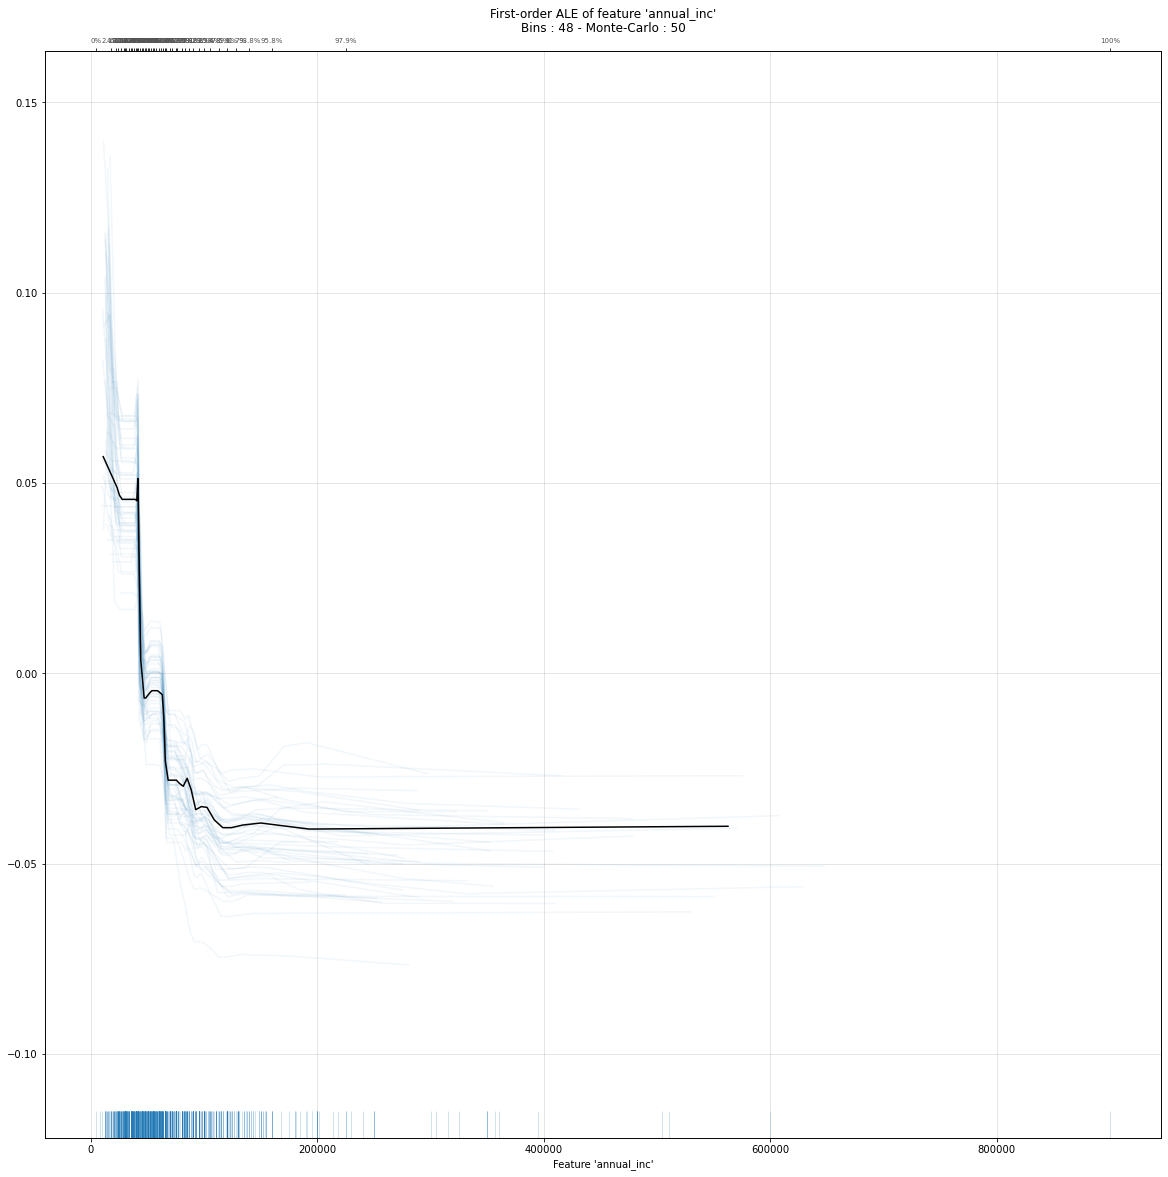

In [91]:
##### Plots ALE of feature 'cont' with Monte-Carlo replicas (default : 50).
fig3, ax3 = ale_plot(model=None, predictor=p, 
         train_set=pred_data, features=['annual_inc'], monte_carlo=True, bins=50, 
                      rugplot_lim=None)
fig3.set_size_inches([20,20])
fig3

In [12]:
import shap

In [9]:
df['id'] = df.index

In [44]:
def p(r):
#     print(r)
    r = pd.DataFrame(r)
    r.columns=df.columns
    preds = []
    for i in range((r.shape[0]-1)//1000+1):
#         print(r.iloc[i*1000:(i+1)*1000])
        pred = d.predict(r.iloc[i*1000:(i+1)*1000]).positiveClassPrediction
        preds.append(pred)
    asd = pd.concat(preds, axis=0)
#     print(asd)
    return asd

In [45]:
def custom_masker(mask, x):
    return (x * mask).reshape(1,len(x))

In [46]:
def p(r):
    r = pd.DataFrame(r)
    r.columns=df.columns
    return d.predict(r).positiveClassPrediction

In [69]:
shap.initjs()

In [73]:
# explainer = shap.Explainer()
explainer = shap.KernelExplainer(model=p, data=df.sample(100), link='logit')

In [74]:
shap_values = explainer.shap_values(pred_data, nsamples=100)

  0%|          | 0/10 [00:00<?, ?it/s]

In [70]:
shap.force_plot(explainer.expected_value, shap_values[0,:], df.iloc[0,:], link="logit")

In [65]:
explainer.expected_value

0.11994506472799998